## Dependencies

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dtw import DTW
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

np.random.seed(42)


## Load dataset

### **Z-Score Normalization of Signals**

To normalize a signal using **Z-score normalization**, apply the following equation:

\[
\text{Normalized Signal} = \frac{X - \mu}{\sigma}
\]

Where:
- \(X\) is the raw signal,
- \(\mu\) is the mean of the signal,
- \(\sigma\) is the standard deviation of the signal.

---

### **Why Normalize?**

- **Amplitude Differences**  
  If two signals have the same shape but different amplitude scales (e.g., one is 2× larger), DTW using raw values may report a high cost despite the shapes being similar.

- **Baseline Wander**  
  ECG signals often experience slow baseline shifts. Subtracting the mean from each signal helps remove this drift.

- **Fair Comparison**  
  Normalizing to zero mean and unit variance ensures that DTW measures shape similarity rather than raw amplitude differences.

In [2]:


def normalize_signals(X):
    X_norm = []
    for row in X:
        mean_val = np.mean(row)
        std_val = np.std(row)
        # Avoid dividing by zero if std is extremely small
        if std_val < 1e-10:
            std_val = 1.0
        row_norm = (row - mean_val) / std_val
        X_norm.append(row_norm)
    return np.array(X_norm)

In [3]:
# Load datasets
train_data = pd.read_csv('../data/ecg_signals/mitbih_train.csv', header=None)
test_data = pd.read_csv('../data/ecg_signals/mitbih_test.csv', header=None)

# Combine for class-based sampling
train_data.columns = list(range(train_data.shape[1]))  # temporary column naming
sampled_data = train_data.groupby(train_data.shape[1]-1).sample(n=15,random_state=42)

# Extract features and labels
X = sampled_data.iloc[:, :-1].values
y = sampled_data.iloc[:, -1].astype(int).values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,stratify=y,shuffle=True,random_state=42)

# Load test set
test_data.columns = list(range(test_data.shape[1]))
sampled_test = test_data.groupby(test_data.shape[1] - 1).sample(n=10, random_state=42)
X_test = sampled_test.iloc[:, :-1].values
y_test = sampled_test.iloc[:, -1].astype(int).values

X_train = normalize_signals(X_train)
X_val   = normalize_signals(X_val)
X_test  = normalize_signals(X_test)

FileNotFoundError: [Errno 2] No such file or directory: '../data/ecg_signals/mitbih_train.csv'

### EDA

#### 🔢 Class Labels in ECG Heartbeat Categorization Dataset (Kaggle)

The dataset uses the AAMI standard to group heartbeats into five major classes:

| Label | Code | Description |
|-------|------|-------------|
| 0     | N    | **Normal and Bundle Branch Block beats** — Includes normal beat (N), left bundle branch block beat (L), right bundle branch block beat (R), atrial escape beat (A), and nodal (junctional) escape beat (J). |
| 1     | S    | **Supraventricular ectopic beats** — Includes atrial premature beat (A), abnormal atrial beat (a), and nodal premature beat (J). These originate above the ventricles but outside the sinus node. |
| 2     | V    | **Ventricular ectopic beats** — Includes premature ventricular contraction (V) and ventricular escape beat (E). These originate in the ventricles and are often considered more serious. |
| 3     | F    | **Fusion beats** — Includes fusion of normal and ventricular beats (F). These occur when both a ventricular and a normal beat activate the ventricles simultaneously. |
| 4     | Q    | **Unknown beats** — Includes paced beats (/), fusion of paced and normal beats (f), and other unclassified beats. These are generally excluded from analysis. |


C:\Users\harsh\AppData\Local\Temp\ipykernel_30516\663069994.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")


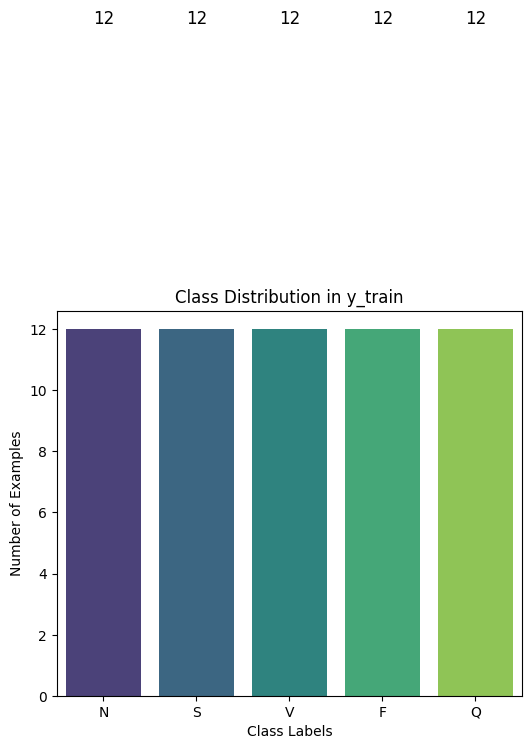

In [ ]:
# Class label mapping
class_mapping = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

# Count occurrences of each class
unique_classes, counts = np.unique(y_train, return_counts=True)


# Plot class distribution
plt.figure(figsize=(6, 5))
sns.barplot(x=list(class_mapping.values()), y=counts, palette="viridis")

# Add labels
plt.xlabel("Class Labels")
plt.ylabel("Number of Examples")
plt.title("Class Distribution in y_train")

# Show values on bars
for i, count in enumerate(counts):
    plt.text(i, count + 10, str(count), ha='center', fontsize=12)

plt.show()

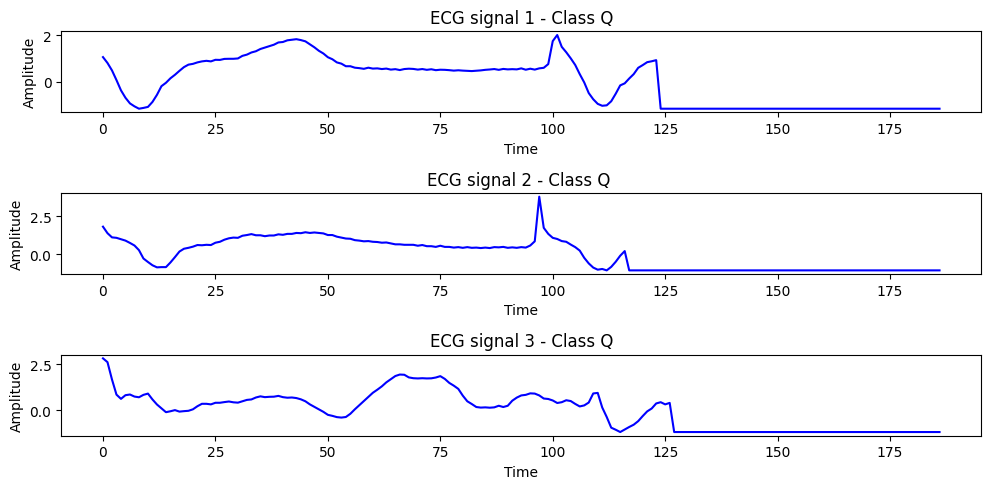

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(X_train[0],label='Sample 1',color='blue',linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'ECG signal 1 - Class {class_mapping[y_train[0]]}')


plt.subplot(3,1,2)
plt.plot(X_train[1],label='Sample 2',color='blue',linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'ECG signal 2 - Class {class_mapping[y_train[1]]} ')


plt.subplot(3,1,3)
plt.plot(X_train[2],label='Sample 3',color='blue',linewidth=1.5)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'ECG signal 3 - Class {class_mapping[y_train[1]]}')


plt.tight_layout()
plt.show()

0.08798939858658114


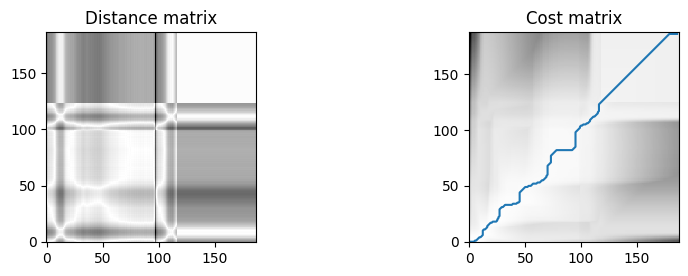

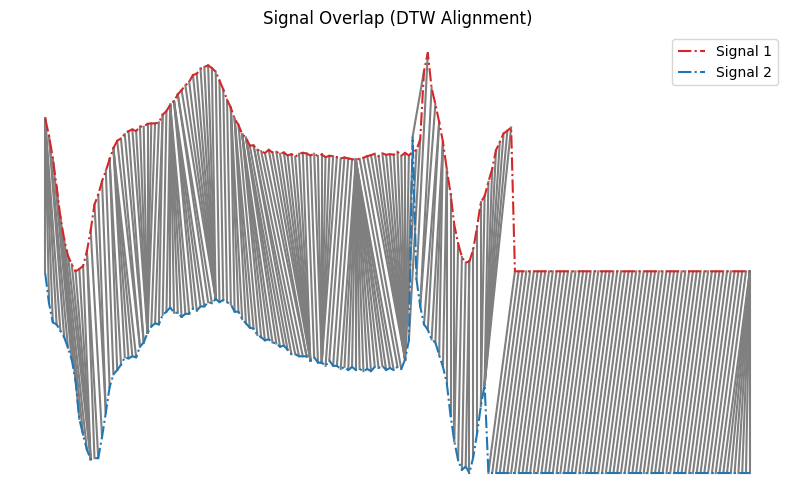

In [ ]:
# Visualize signals 1 & 2 for using DTW

dtw_model = DTW(signal1=X_train[0],signal2=X_train[1])
distance = dtw_model.compute()
print(distance)
dtw_model.visualize()

0.16087516517373074


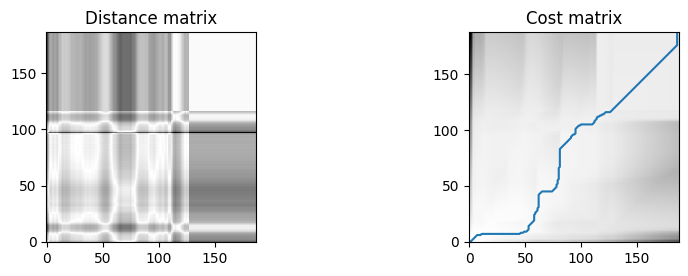

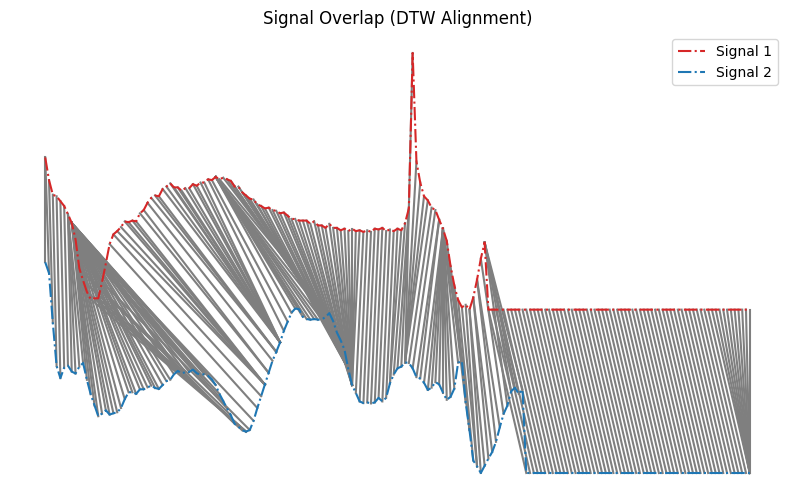

In [ ]:
# Visualize signals 2 & 3 for using DTW

dtw_model = DTW(signal1=X_train[1],signal2=X_train[2])
distance = dtw_model.compute()
print(distance)
dtw_model.visualize()

## Training

### Train KNN-DTW classifier

In [ ]:
def dtw_wrapper(x, y):
    return DTW(x, y, normalized=True).compute()

# Had to stop the model at 547 minutes, took too long to run on full dataset
# took 22 minutes for 40 samples

model = KNeighborsClassifier(n_neighbors=3,metric=dtw_wrapper)
model.fit(X_train,y_train)
y_val_pred = model.predict(X_val)

In [ ]:
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.33      0.33      0.33         3
           2       0.50      0.33      0.40         3
           3       0.67      0.67      0.67         3
           4       1.00      0.67      0.80         3

    accuracy                           0.53        15
   macro avg       0.58      0.53      0.54        15
weighted avg       0.58      0.53      0.54        15



In [ ]:
joblib.dump(model, './saved_models/dtw_knn_model.pkl')

['dtw_knn_model.pkl']

### Train KNN-fastDTW classifier

In [ ]:
def fast_dtw_wrapper(x, y):
    distance, _ = fastdtw(x, y, dist=euclidean)
    return distance

model_2 = KNeighborsClassifier(n_neighbors=3, metric=fast_dtw_wrapper)
model_2.fit(X_train, y_train)
y_val_pred = model_2.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

In [ ]:
joblib.dump(model, './saved_models/fast_dtw_knn_model.pkl')

### Train KNN-Euclidean classifier

In [ ]:
model_3 = KNeighborsClassifier(n_neighbors=3,metric="euclidean")
model_3.fit(X_train,y_train)
y_val_pred = model_3.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Accuracy: 0.6
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.67      0.67      0.67         3
           2       0.50      0.33      0.40         3
           3       0.50      1.00      0.67         3
           4       1.00      0.67      0.80         3

    accuracy                           0.60        15
   macro avg       0.63      0.60      0.59        15
weighted avg       0.63      0.60      0.59        15



## Test

In [ ]:
# KNN-DTW
y_pred_dtw = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_dtw))
print(classification_report(y_test, y_pred_dtw))

Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.71      0.50      0.59        10
           2       1.00      0.50      0.67        10
           3       0.60      0.90      0.72        10
           4       0.82      0.90      0.86        10

    accuracy                           0.68        50
   macro avg       0.73      0.68      0.68        50
weighted avg       0.73      0.68      0.68        50



In [ ]:
#KNN-Euclidean
y_pred_euc = model_2.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_euc))
print(classification_report(y_test, y_pred_euc))

Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        10
           1       0.75      0.60      0.67        10
           2       1.00      0.50      0.67        10
           3       0.47      0.90      0.62        10
           4       0.69      0.90      0.78        10

    accuracy                           0.64        50
   macro avg       0.70      0.64      0.63        50
weighted avg       0.70      0.64      0.63        50

